# Using fCWT in Python

Import required packages

In [1]:
import fcwt
import numpy as np
import matplotlib.pyplot as plt

Generate a 100s syntethic linear chirp signal

In [2]:
fs = 1000
n = fs*100 #100 seconds
ts = np.arange(n)

#Generate linear chirp
signal = np.sin(2*np.pi*((0.1+(2*ts)/n)*(ts/fs)))

### Quick analysis

We can use fCWT's boilerplate code to quickly plot the CWT representation of the signal. 

**fcwt.plot(signal,fs,f0,f1,fn,nthreads,scaling,fast,norm)**

|Arguments  |Description                |Default value|
|:----------|:--------------------------|:------------|
|signal     |signal to be analyzed      |-            |
|fs         |sampling frequency         |-            |
|f0         |lowest frequency           | lowest frequency possible |
|f1         |highest frequency          | nyquist frequency |
|fn         |number of frequencies      | 100         |
|nthreads   |number of threads to use   | 1 (rule of thumb: use number of cores) |
|scaling    |scaling of frequencies (lin or log)*  | lin         |
|fast       |use optimization plans**    | False       |
|norm       |normalize time-frequency output |True    |

*See section 'Scaling' for more information

**See section 'Optimization plans' for more information

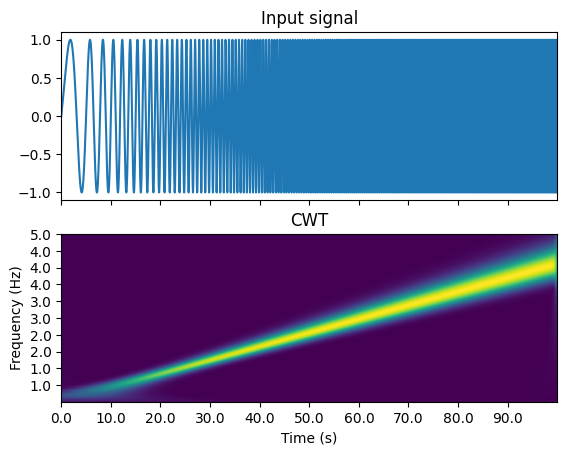

In [3]:
f0 = 0.1 #lowest frequency
f1 = 5 #highest frequency
fn = 300 #number of frequencies

#plot cwt
fcwt.plot(signal, fs, f0=f0, f1=f1, fn=fn)

If we want the actual time-frequency matrix, we can use fCWT's `cwt` function that has similar arguments as the `plot` function except that it does not infer the frequency range. You have to provide f0, f1 and fn.

**frequencies, cwt = fcwt.cwt(signal,fs,f0,f1,fn,nthreads,scaling,fast,norm)**

|Arguments  |Description                |Default value|
|:----------|:--------------------------|:------------|
|signal     |signal to be analyzed      |-            |
|fs         |sampling frequency         |-            |
|f0         |lowest frequency           |-            |
|f1         |highest frequency          |-            |
|fn         |number of frequencies      |-            |
|nthreads   |number of threads to use   | 1 (rule of thumb: use number of cores) |
|scaling    |scaling of frequencies (lin or log)*  | lin         |
|fast       |use optimization plans**    | False       |
|norm       |normalize time-frequency output |True    |

In [4]:
freqs, cwt = fcwt.cwt(signal, fs, f0, f1, fn)
print(cwt.shape)

(300, 100000)


## Advanced usage

If you know a bit about wavelet theory or the continuous wavelet transform in general, you can choose to use the advanced interface to fCWT. The advanced interface gives users a lot of freedom. It gives the possibility to adjust the wavelet parameters, reuse the time-frequency matrix memory and FFTW optimization plans to speed up calculations and access the actual wavelet scales in addition to frequencies.  

Advanced usage involves a few specific steps:
1. Make sure that the input is an array of floats (not doubles)
2. Create the `Morlet` object
3. Create the `Scales` object that translates your frequency range to a scale range depending on the wavelet type
4. Initializing a `FCWT` object
5. Allocating memory for the time-frequency matrix using `np.zeros(...,dtype=np.complex64)`
6. Calculating the CWT using the fcwt-object


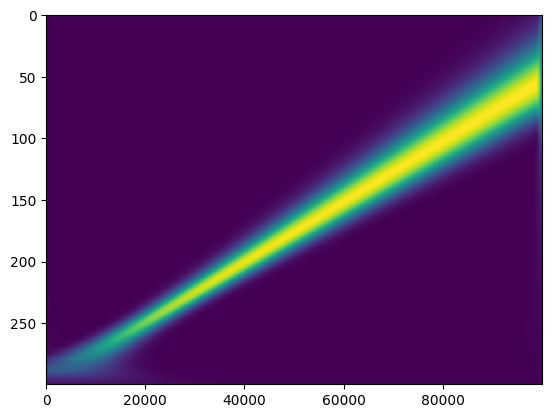

In [5]:
#make sure signal is a numpy float array
signal = np.array(signal, dtype=np.float32)

#initialize Morlet wavelet with wavelet parameter (sigma) 2.0
morl = fcwt.Morlet(2.0)

#initialize scales
scales = fcwt.Scales(morl, fcwt.FCWT_LINFREQS, fs, f0, f1, fn)

#initialize fcwt
nthreads = 8
use_optimization_plan = False
use_normalization = True
fcwt_obj = fcwt.FCWT(morl, nthreads, use_optimization_plan, use_normalization)

#initialize output array
output = np.zeros((fn,signal.size), dtype=np.complex64)

#calculate cwt
fcwt_obj.cwt(signal, scales, output)

#plot cwt
plt.imshow(np.abs(output),aspect='auto')
plt.show()

### Complex valued input

Although real valued inputs are much more common, fCWT can also handle complex valued inputs. Using complex valued inputs is simple. Instead of using `fcwt.cwt` one uses `fcwt.ccwt`.

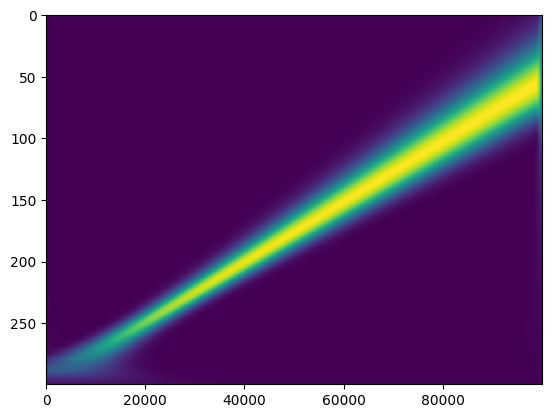

In [6]:
#create complex version of signal
csignal = signal + 1j*0

#calculate cwt using ccwt function
fcwt_obj.ccwt(csignal, scales, output)

#plot cwt
plt.imshow(np.abs(output),aspect='auto')
plt.show()

### Optimization plans

fCWT can be accelerated by creating optimization plans for the underlying FFTW library. fCWT provides a wrapper function that generates such plans for a specific combination of hardware and signal length. As such, plans created for hardware setup X tend to lose performance on hardware setup Y. However, plans do work for all signal lengths up to the length for which the plan was created!

**FCWT_OBJ.create_optimization_plan(N, type)**

|Arguments      |Description        |Default value|
|:--------------|:------------------|:------------|
|N              |Maximum signal length for which to create a plan| - |
|Type           |Optimization technique to use | - |

Plans are created for all powers of 2 up until the smallest power of 2 that is larger than N. 

Optimization techniques are denoted by a string corresponding to the optimization type used (see FFTW's planner flags: https://www.fftw.org/fftw3_doc/Planner-Flags.html).

|Plan               |Description|
|:------------------|:------------|
|FFTW_ESTIMATE      |Very fast but non-optimal optimization strategy  |
|FFTW_MEASURE       |Fast optimization, but better than FFTW_ESTIMATE |
|FFTW_PATIENT       |Slow optimization but tends to optimize well |
|FFTW_EXHAUSTIVE    |Very slow optimization for optimal optimization in some cases |

In [7]:
#first set the use_optimization_plan flag to True
use_optimization_plan = True

#create a new fcwt object
fcwt_obj_optimized = fcwt.FCWT(morl, nthreads, use_optimization_plan, False)

#create optimization plan for the fcwt object and signal length 10000
fcwt_obj_optimized.create_FFT_optimization_plan(100000, "FFTW_ESTIMATE")

Threads:8
Calculating optimal scheme for forward FFT with N:2048
Calculating optimal scheme for backward FFT with N:2048
Optimization schemes for N: 2048 have been calculated. Next time you use fCWT it will automatically choose the right optimization scheme based on number of threads and signal length.
Threads:8
Calculating optimal scheme for forward FFT with N:4096
Calculating optimal scheme for backward FFT with N:4096
Optimization schemes for N: 4096 have been calculated. Next time you use fCWT it will automatically choose the right optimization scheme based on number of threads and signal length.
Threads:8
Calculating optimal scheme for forward FFT with N:8192
Calculating optimal scheme for backward FFT with N:8192
Optimization schemes for N: 8192 have been calculated. Next time you use fCWT it will automatically choose the right optimization scheme based on number of threads and signal length.
Threads:8
Calculating optimal scheme for forward FFT with N:16384
Calculating optimal sc

It is now possible to set the use_optimization_plan flag to true.

In [8]:
fcwt_obj_optimized.cwt(signal, scales, output)

We can now calculate the difference in performance:

In [9]:
#time the fcwt calculation using timeit library
import timeit
timeit.timeit('fcwt_obj.cwt(signal, scales, output)', number=10, globals=globals())


0.8421905200002584

In [10]:

#time the fcwt calculation with optimization plan using timeit library
timeit.timeit('fcwt_obj_optimized.cwt(signal, scales, output)', number=10, globals=globals())

0.540503727000214

As you can see we gain an almost 50% boost in speed. As such, in cases where fCWT is calculated many times, it is very beneficial to pre-calculate optimization plans.

### Scales

Typically, the CWT uses an inverse logarithmic frequency scaling to analyse a signal. Wavelet scales are defined such that they are evenly spaced in exponential space (often base 2). However, we understand that a linear frequency scaling is sometimes preferable for interpretation. Hence, we allowed users to choose between both types of scaling. In the boilerplate wrapper functions this can be done via the `scaling` parameter. In the advanced user interface, this is typically done using the `fcwt.FCWT_LOGSCALES` or `fcwt.FCWT_LINFREQS` constants. 

The difference between both scalings can be easily seen:

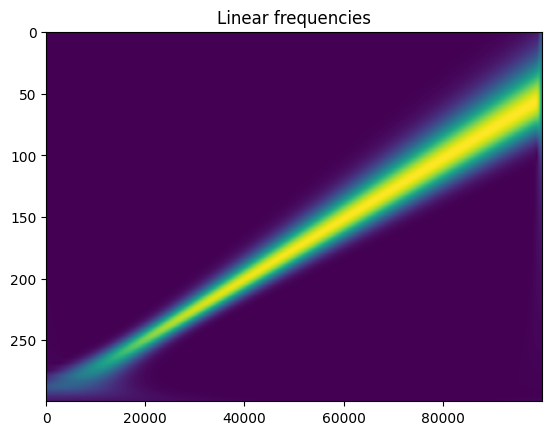

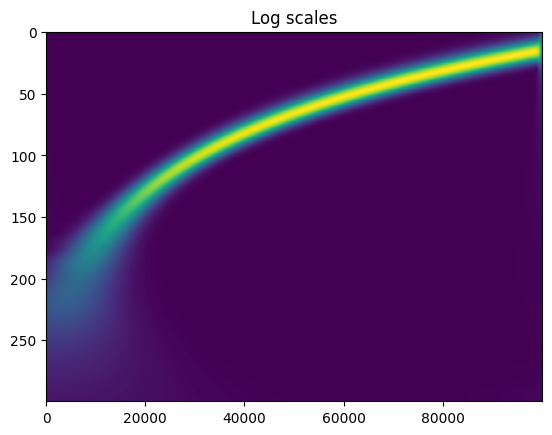

In [11]:
linscales = fcwt.Scales(morl, fcwt.FCWT_LINFREQS, fs, f0, f1, fn)
logscales = fcwt.Scales(morl, fcwt.FCWT_LOGSCALES, fs, f0, f1, fn)

fcwt_obj.cwt(signal, linscales, output)

plt.imshow(np.abs(output),aspect='auto')
plt.title('Linear frequencies')
plt.show()


fcwt_obj.cwt(signal, logscales, output)

plt.imshow(np.abs(output),aspect='auto')
plt.title('Log scales')
plt.show()